# Combined Drought Index

## Background

The Enhanced Combined Drought Index is calculated as follows:

<img src="../data/EnhancedCombinedDroughtIndex.png">

with the weight for each individual drought index derived as follows:

<img src="../data/DroughtIndexWeights.png">

## Description



The notebook outlines:

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages


In [1]:
import pickle
from datetime import datetime

import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

### Analysis parameters

The following cell sets important parameters for the analysis:

In [2]:
# The county to calculate the ECDI for.
county = "Turkana"

## Load the drought indices

In [3]:
# Load the Precipitation Drought Index.
pdi_fn = f"results/{county}_county_pdi.pickle"
with open(pdi_fn, "rb") as file:
    PDI = pickle.load(file)

# Load the Temperature Drought Index.
tdi_fn = f"results/{county}_county_tdi.pickle"
with open(tdi_fn, "rb") as file:
    TDI = pickle.load(file)

# Load the Vegatation Drought Index.
vdi_fn = f"results/{county}_county_vdi.pickle"
with open(vdi_fn, "rb") as file:
    VDI = pickle.load(file)

# Load the county mask.
mask_fn = f"results/{county}_county_mask.pickle"
with open(mask_fn, "rb") as file:
    county_mask = pickle.load(file)

## Format the drought indices

In [4]:
# Get the attributes from the PDI xarray dataset to use later.
attrs = PDI.attrs

In [5]:
# The time range for the PDI is 1981-01-01 to 2022-05-01.
# The time range for the VDI and TDI is 1984-04-01 to 2022-08-01.
# Slice the data arrays so that they will all have the same time range.
start = "1984-04"
end = "2022-05"
PDI = PDI.PDI.sel(time=slice(start, end))
TDI = TDI.TDI.sel(time=slice(start, end))
VDI = VDI.VDI.sel(time=slice(start, end))

## Calculate the weights for each drought index

The weight of each individual index is automatically calculated with respect to its capability to reflect the future vegetation status (NDVI).

The Precipitation Drought Index and the Temperature Drought Index are correlated with the Vegetation Drought index via Pearson’s correlation coefficient (R).


In [6]:
%%time
def get_max_correlation_lag(reference_index, drought_index, mask=None):
    # Find the 'lag' value for each pixel, where shifting the time series of the drought_index
    # 'lag' time steps to the right results in the highest correlation with the reference_index.

    # Create xarray.DataArray to track the maximum correlation achieved
    # between the reference_index and the shifted drought_index for each pixel.
    # Starts from correlation with no shift.
    max_correlation = xr.corr(reference_index, drought_index, dim="time")
    # Empty xarray.DataArray to track the lag value at which maximum correlation was achieved
    # between the reference_index and the shifted drought_index for each pixel.
    # Starts from 'lag' value is 0 indicating no shift.
    max_lag = xr.full_like(reference_index.isel(time=0), 0)

    # Lag values to test for.
    # Note the reference_index and drought index must have the same number of time steps.
    lags = list(range(1, len(reference_index.time.values) + 1))

    # Loop over the range of lag values to test (lags).
    for i in lags:
        # Get the correlation between the reference index and the shifted drought index.
        corr = xr.corr(reference_index, drought_index.shift(time=i), dim="time")
        # If the current correlation value (corr) is greater then the max correlation value for a pixel
        # (max_correlation) then assign the current lag value to max_lag.
        max_lag = xr.where(corr > max_correlation, i, max_lag)
        # If the current correlation value (corr) is greater then the max correlation value for a pixel
        # (max_correlation) then assign the corr value to max_correlation.
        max_correlation = xr.where(corr > max_correlation, corr, max_correlation)

    # If there is a mask provided, use it to mask the max_correlation and
    # max_lag xarray.DataArrays.
    if mask is not None:
        max_correlation = max_correlation.where(mask)
        max_lag = max_lag.where(mask)

    return max_correlation, max_lag


PDI_max_correlation, PDI_max_lag = get_max_correlation_lag(
    reference_index=VDI, drought_index=PDI, mask=county_mask
)
TDI_max_correlation, TDI_max_lag = get_max_correlation_lag(
    reference_index=VDI, drought_index=TDI, mask=county_mask
)
VDI_max_correlation, VDI_max_lag = get_max_correlation_lag(
    reference_index=VDI, drought_index=VDI, mask=county_mask
)

CPU times: user 2min 4s, sys: 38.5 s, total: 2min 43s
Wall time: 2min 43s


In [7]:
# The weight of each drought index is automatically calculated with respect to
# its capability to reflect the future vegetation status (NDVI).
# The weights are distributed according to the quality of the correlation
# and the time step at which the highest correlations are observed.
PDI_weight = (
    ((PDI_max_lag / (PDI_max_lag + TDI_max_lag + VDI_max_lag)) * 100)
    + (
        (
            PDI_max_correlation
            / (PDI_max_correlation + TDI_max_correlation + VDI_max_correlation)
        )
        * 100
    )
) / 2
TDI_weight = (
    ((TDI_max_lag / (PDI_max_lag + TDI_max_lag + VDI_max_lag)) * 100)
    + (
        (
            TDI_max_correlation
            / (PDI_max_correlation + TDI_max_correlation + VDI_max_correlation)
        )
        * 100
    )
) / 2
VDI_weight = (
    ((VDI_max_lag / (PDI_max_lag + TDI_max_lag + VDI_max_lag)) * 100)
    + (
        (
            VDI_max_correlation
            / (PDI_max_correlation + TDI_max_correlation + VDI_max_correlation)
        )
        * 100
    )
) / 2

In [8]:
# The sum of all weights per time step is one or 100%.
np.unique(PDI_weight + TDI_weight + VDI_weight)

array([100., 100., 100., 100., 100.,  nan])

In [9]:
# Calculate the Enhanced Combined Drought Index.
ECDI = (PDI_weight * PDI) + (TDI_weight * TDI) + (VDI_weight * VDI)

# Convert the xarray.DataArray to a xarray.Dataset.
ECDI = ECDI.to_dataset(name="ECDI").transpose("time", "y", "x")
ECDI.attrs = attrs
ECDI

<xarray.Dataset>
Dimensions:  (y: 115, x: 54, time: 458)
Coordinates:
  * y        (y) float64 6.875e+05 6.825e+05 6.775e+05 ... 1.225e+05 1.175e+05
  * x        (x) float64 3.278e+06 3.282e+06 3.288e+06 ... 3.538e+06 3.542e+06
  * time     (time) datetime64[ns] 1984-04-01 1984-05-01 ... 2022-05-01
Data variables:
    ECDI     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

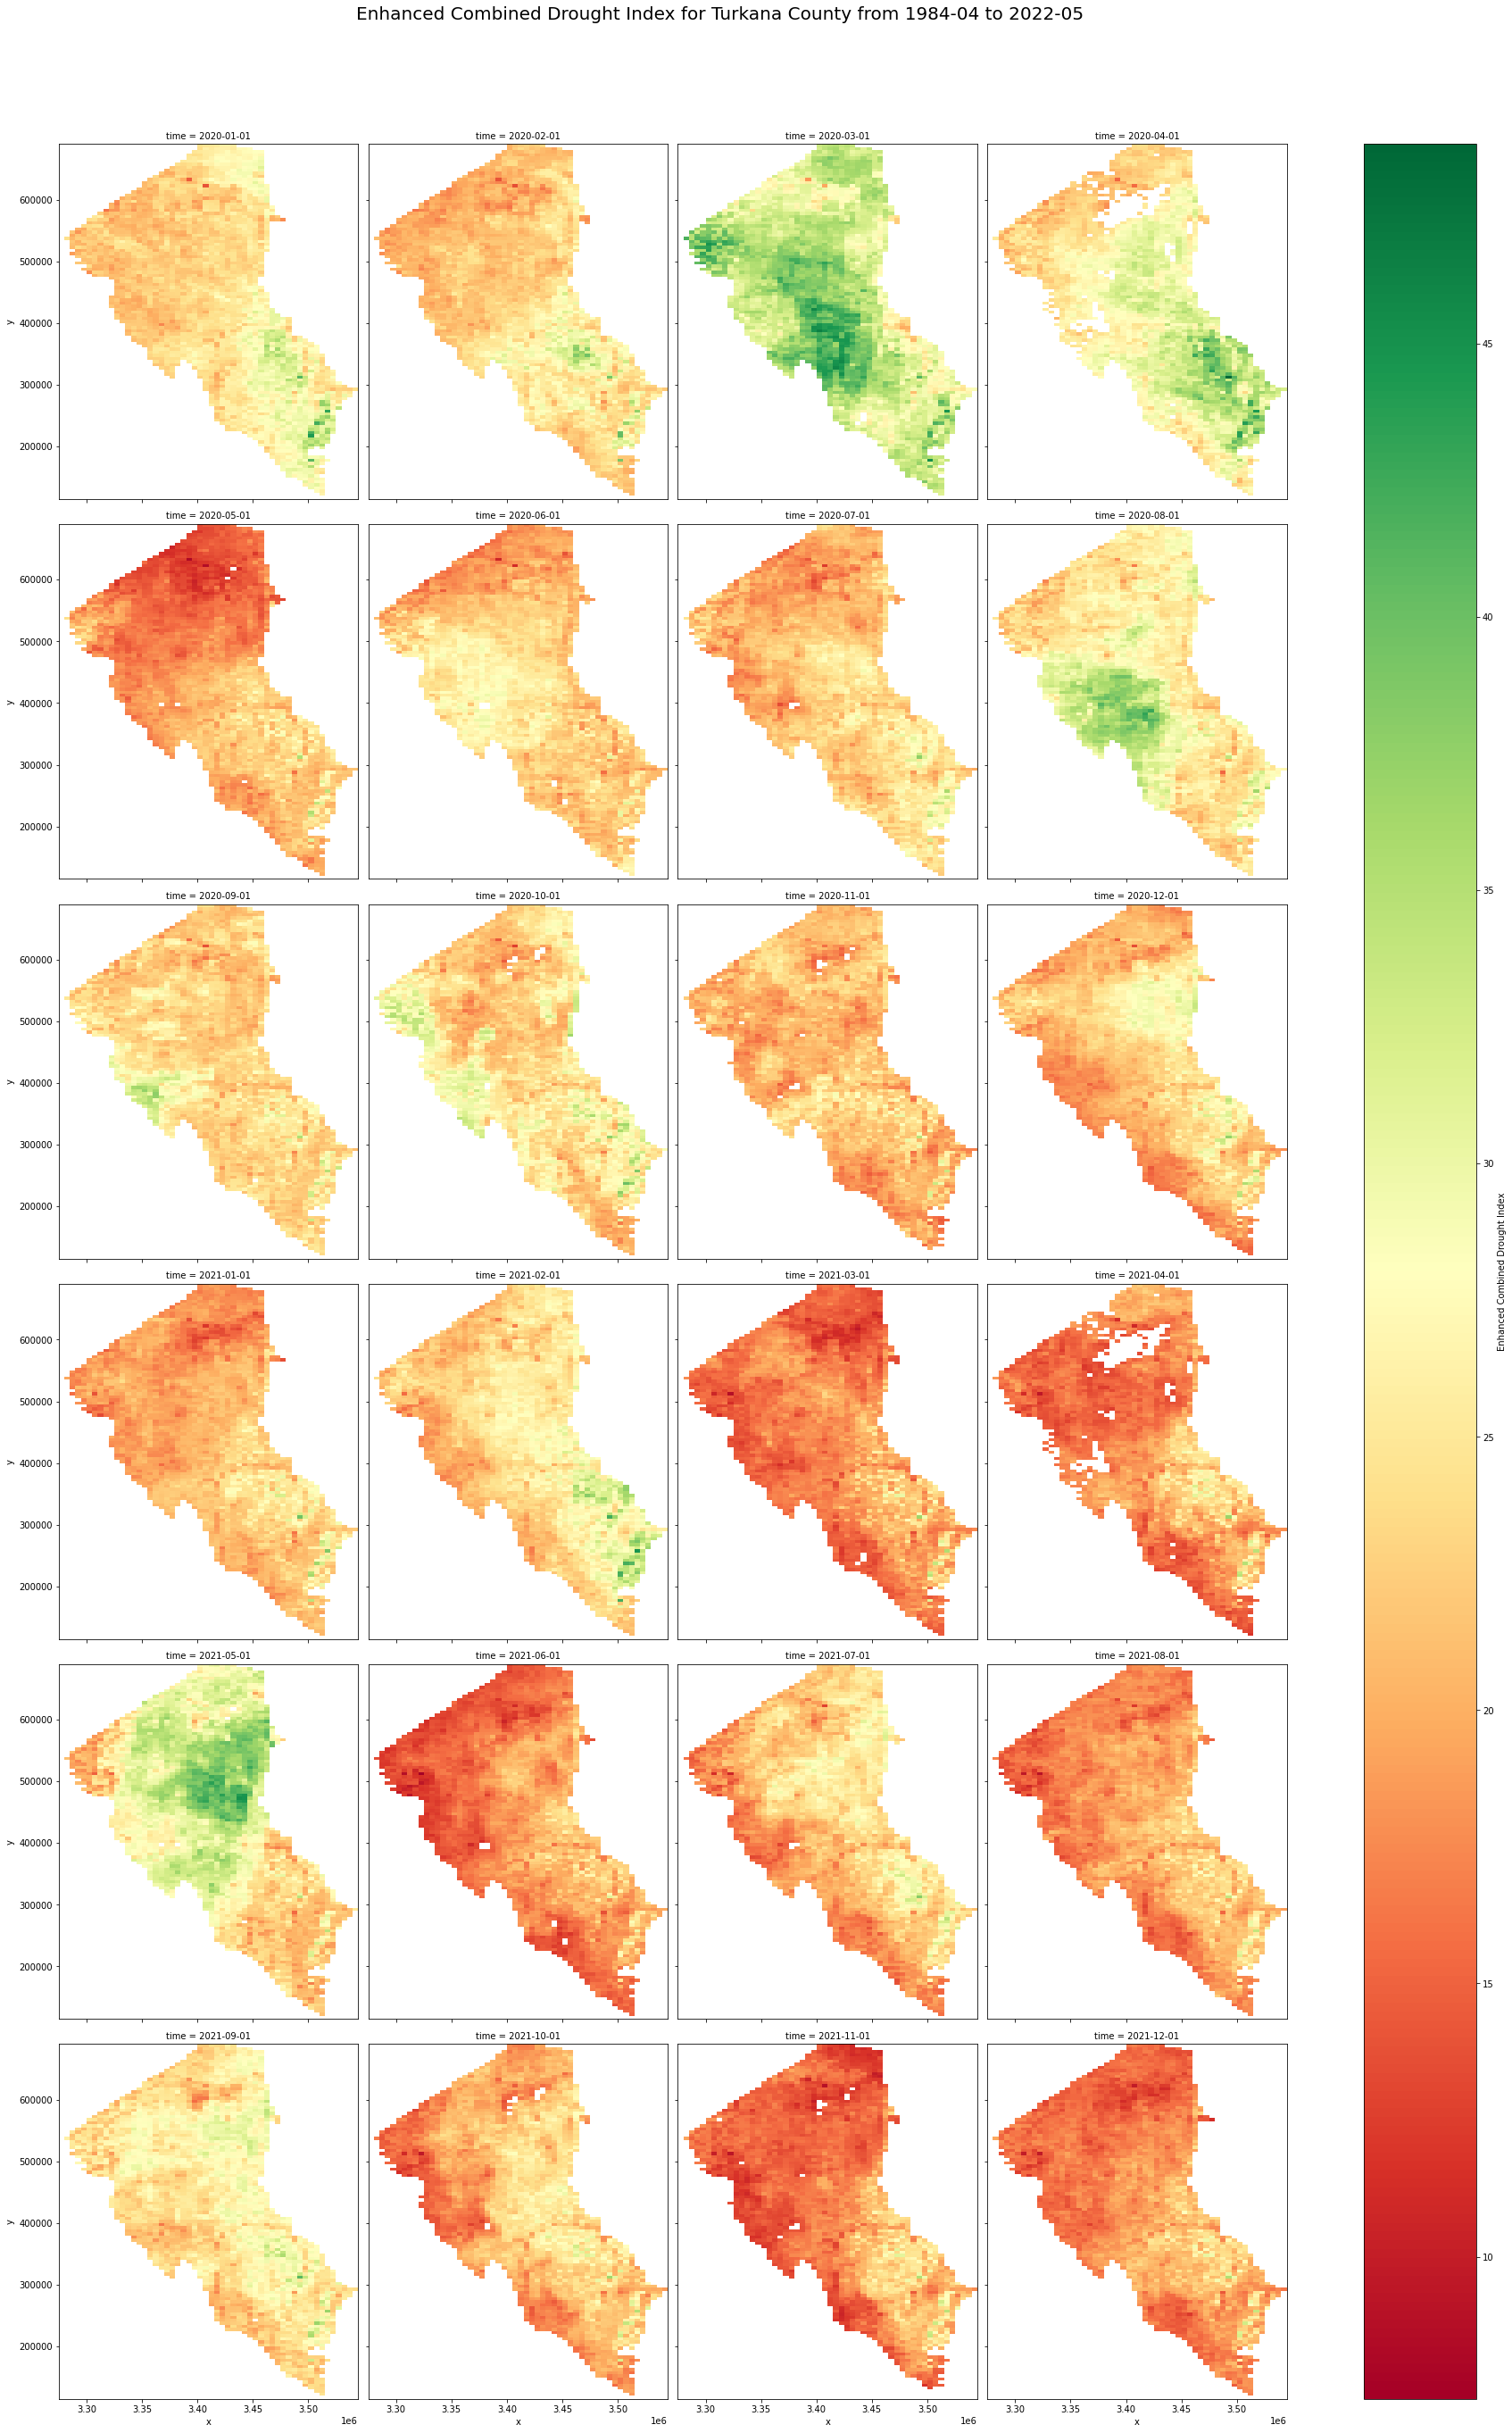

In [10]:
# Plot the Enhanced Combined Drought Index for the years 2020 and 2021.
fig = ECDI.ECDI.sel(time=slice("2020", "2021")).plot(
    x="x",
    y="y",
    col="time",
    col_wrap=4,
    cbar_kwargs={"label": "Enhanced Combined Drought Index"},
    size=6,
    cmap="RdYlGn",
)

fig.fig.suptitle(
    f"Enhanced Combined Drought Index for {county} County from {start} to {end}",
    fontsize=20,
    x=0.45,
    y=1.05,
)

fig.fig.savefig(f"results/ecdi_{county}_{start}_to_{end}.png", bbox_inches="tight")

## Drought Risk Warning Levels

<img src="../data/DroughtRiskWarningLevels.png">

<img src="../data/MSFFoodSecurityWarningLevels.png">

In [11]:
def get_monthly_mean(ds):
    monthly_mean = ds.groupby("time.month").mean("time")
    return monthly_mean


def get_monthly_std(ds):
    monthly_std = ds.groupby("time.month").std("time")
    return monthly_std


# Group the ECDI dataset by year then month.
monthly_mean_ECDI = (
    ECDI.ECDI.groupby("time.year")
    .map(get_monthly_mean)
    .transpose("year", "month", "y", "x")
)
# Get the long term average ECDI for each month.
climatology_mean_ECDI = get_monthly_mean(ECDI).transpose("month", "y", "x")
climatology_std_ECDI = get_monthly_std(ECDI).transpose("month", "y", "x")

In [12]:
ECDI_warning_levels = (monthly_mean_ECDI - climatology_mean_ECDI) / climatology_std_ECDI

# Convert to xarray.DataArray.
ECDI_warning_levels = ECDI_warning_levels.ECDI

# Add a time dimension to the xarray.DataArray.
time_list = []
data_list = []
for year in ECDI_warning_levels.year.values:
    ds_year = ECDI_warning_levels.sel(year=year)
    for month in ds_year.month.values:
        ds_month = ds_year.sel(month=month)
        ds_month_np = ds_month.data
        data_list.append(ds_month_np)
        # Specify the time step to be the first day of the month.
        time_step = f"{year}-{month:02}-01"
        time_list.append(time_step)


# Convert the time_list to a numpy array.
time = np.array(time_list, dtype="datetime64[ns]")
# Stack the numpy arrays in the data_list.
data = np.stack(data_list, axis=0)

# Initialize dataset.
ECDI_warning_levels = xr.Dataset(
    data_vars=dict(Drought_Risk_Warning_Levels=(["time", "y", "x"], data)),
    coords=dict(
        time=(["time"], time),
        y=(["y"], ECDI_warning_levels.y.values),
        x=(["x"], ECDI_warning_levels.x.values),
    ),
    attrs=attrs,
)

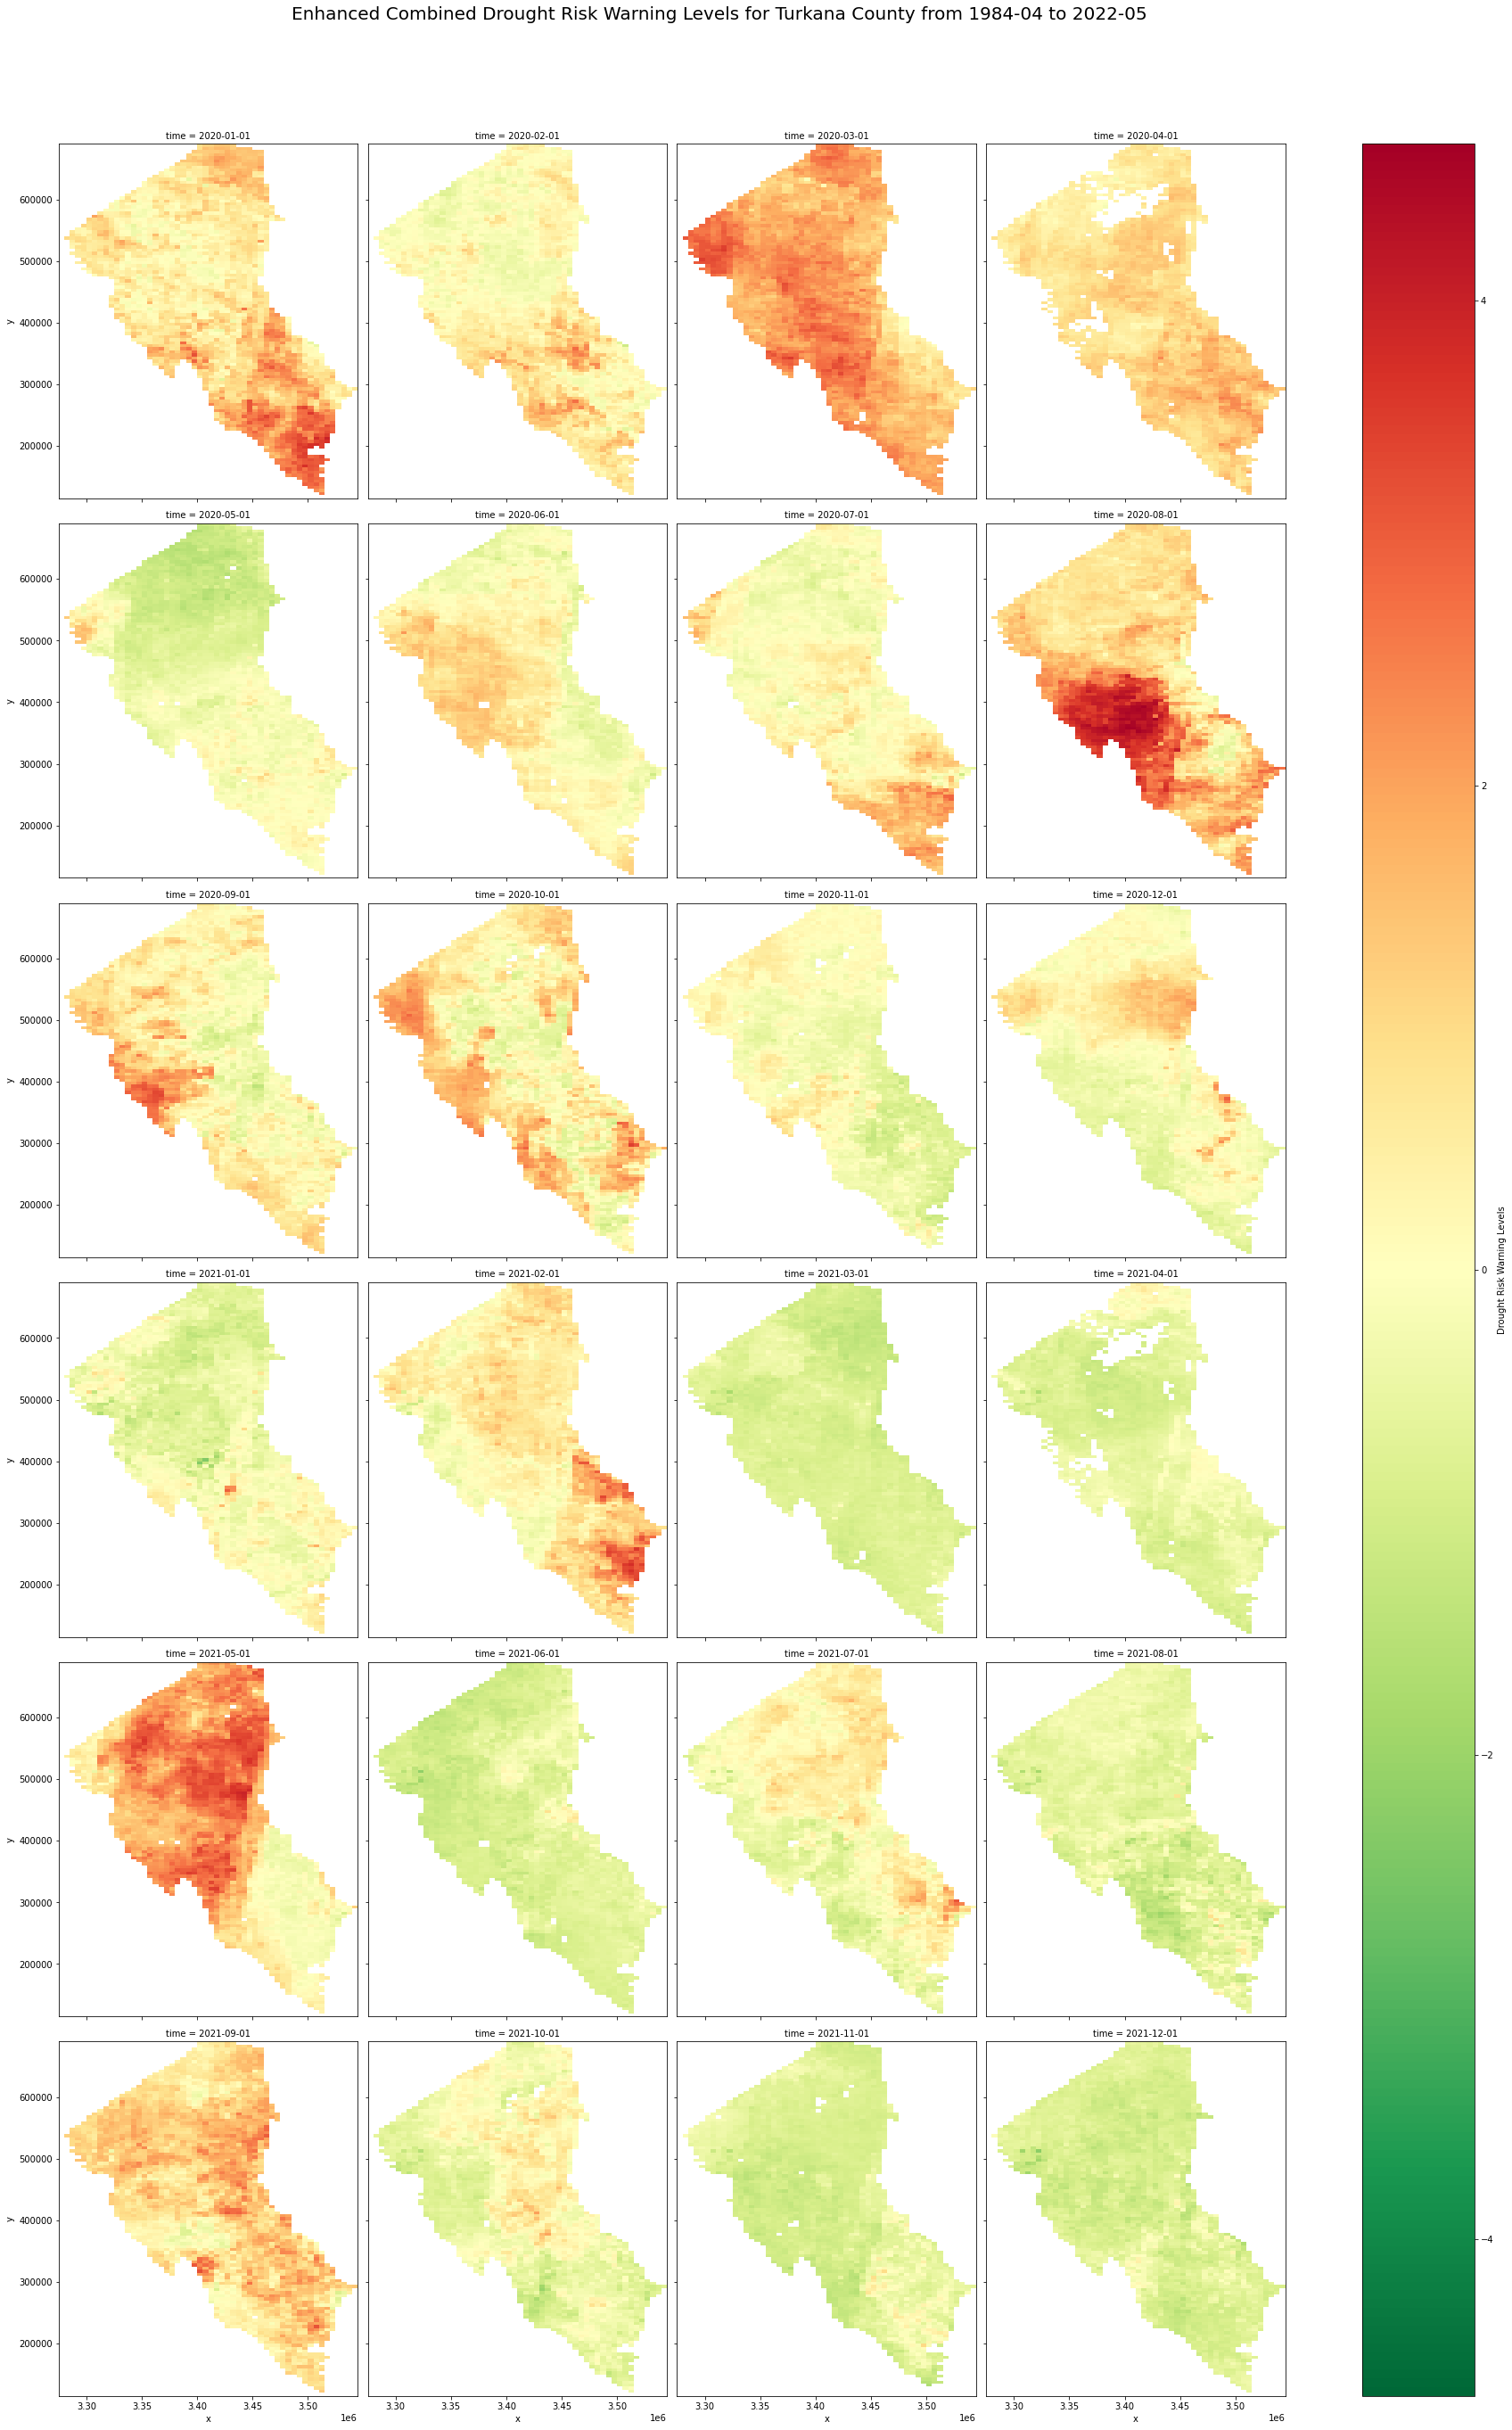

In [13]:
fig = (
    ECDI_warning_levels["Drought_Risk_Warning_Levels"]
    .sel(time=slice("2020", "2021"))
    .plot(
        x="x",
        y="y",
        col="time",
        col_wrap=4,
        cbar_kwargs={"label": "Drought Risk Warning Levels"},
        size=6,
        cmap="RdYlGn_r",
    )
)


fig.fig.suptitle(
    f"Enhanced Combined Drought Risk Warning Levels for {county} County from {start} to {end}",
    fontsize=20,
    x=0.45,
    y=1.05,
)

fig.fig.savefig(
    f"results/ecdi_warning_levels_{county}_{start}_to_{end}.png", bbox_inches="tight"
)